# Análise de Similaridade entre Tweets e conteúdos de Artigos Científicos

Montando a pasta do Google Drive para acesso pelo Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = './drive/MyDrive/fake-tweet-detector/assets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Leitura dos arquivos e geração de sentenças

Lendo o arquivo completo de artigos e interpretando o JSON como um dicionário no Python

In [2]:
import json

with open(DATA_DIR + 'article_full_section.json', 'r') as f:
  articles = json.load(f)

Utilizando a biblioteca *nltk* como auxílio para a geração de sentenças a partir do conteúdo de cada um dos artigos.


In [3]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from nltk import tokenize
import nltk
import re
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
for id, content in articles.items():
  sentences = tokenize.sent_tokenize(content)
  sentences = [re.sub(r'\([^()]*\)|[\)\(]|([.,!?()\\-]|[^\x00-\x7F]+)', '', sentence).strip() for sentence in sentences]
  articles.update({ id:  list(filter(None, sentences)) })

In [6]:
articles['1']

['Based on the current knowledge of severe acute respiratory syndrome coronavirus2  transmission wearing a mask has been recommended during the COVID19 pandemic',
 'Bacterial filtration efficiency  measurements enable designing and regulating medical masks to prevent bioaerosol dissemination; however despite the simplicity of these measurements several scientific questions remain unanswered regarding BFE tests',
 'Here we investigated  the impact of substituting 100mm Petri dishes with 90mm disposable Petri dishes  the impact of colonycounting methods on the bioaerosol aerodynamic size and  the impact of colonycounting methods on the total viable particle counts',
 'We demonstrated that disposable 90mm Petri dishes can be used to replace the 100mm dishes',
 'We also showed that an automatic highresolution colony counter can be used to directly count viable particles on collection substrates and to measure the bioaerosol size parameters',
 'Our results enable possible modernization of t

In [7]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download("stopwords")

ps = PorterStemmer()

def textToStemTokens(text: str):
  tokens = nltk.word_tokenize(text)
  stem = []  
  for word in tokens:
    if (
      re.fullmatch(r"[a-z]+", word)
      and word not in stopwords.words("english")
      and len(word) > 1
    ):
      stem.append(ps.stem(word))
  return stem

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
tokenizedArticles = {}

for id, content in articles.items():
  val = [" ".join(textToStemTokens(sentence)) for sentence in content]
  tokenizedArticles.update({ id: val })
    

Lendo os arquivos de tweets e interpretando o JSON como um dicionário no Python

In [9]:
with open(DATA_DIR + 'tweet_full.json', 'r') as f:
  tweets = json.load(f)

with open(DATA_DIR + 'tweet_root_words.json', 'r') as f:
  tweets_root = json.load(f)

### Criando uma amostra dos tweets para análise

In [10]:
tweet_keys = list(tweets.keys())[:500]

for k in tweet_keys:
  tweets.update({ k: re.sub('[.,!?\\-]', '', tweets[k]) })

## Análise de Similaridade

### Definição do modelo treinado

Aqui se utiliza da biblioteca **sentence_transformers** como forma de importar um modelo treinado para a análise.

In [11]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.6 MB/s 
     |████████████████████████████████| 5.8 MB 11.0 MB/s 
     |████████████████████████████████| 1.3 MB 15.1 MB/s 
     |████████████████████████████████| 182 kB 10.5 MB/s 
     |████████████████████████████████| 7.6 MB 43.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=74651d549a1cce7444a1db160b4ae572b3fbad3f158ff99a793cb8767367a704
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


O modelo selecionado para o trabalho é o `all-mpnet-base-v2`



In [12]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

### Gerando *Sentence Embeddings*

* Conjunto de técnicas de PLN onde sentenças são mapeadas para vetores de números reais,

In [13]:
from sentence_transformers import util
from torch import Tensor
from typing import List, Dict

In [14]:
articleSentences = []
articleSupLim = {}

In [15]:
accLim = 0
for articleId, sentences in articles.items():
  for sentence in sentences:
    articleSentences.append(sentence)
  accLim = accLim + len(sentences)
  articleSupLim.update({ articleId: accLim - 1 })

In [16]:
articleSupLim

{'1': 87, '2': 96, '3': 312, '4': 408, '5': 505}

In [17]:
articleEmbeddings = model.encode(articleSentences, convert_to_tensor=True)

In [18]:
tweetEmbeddings = model.encode(list(tweets.values()), convert_to_tensor=True)

### Realizando a análise de similaridade semântica para sentenças completas

In [19]:
cosine = util.cos_sim(articleEmbeddings, tweetEmbeddings)

In [20]:
def getArticleIdByIndex(limits, index):
  for id, limit in limits.items():
    if (index <= limit):
      return id, limit - index

In [21]:
pairs = {}
cosineValues = []

for i in range(len(articleSentences)):
  for j in range(len(tweet_keys)):
    score = cosine[i][j]

    tweetKey = tweet_keys[j]

    tweet = tweets.get(tweetKey)
    
    if tweet:   
      articleId, index = getArticleIdByIndex(articleSupLim, i)
      articleSentence = articles.get(articleId)[index]
    
      sentences = pairs.get(tweetKey)

      if not sentences:
        sentences = []

      sentences.append({
        'tweet': tweet,
        'articleId': articleId,
        'articleSentence': articleSentence,
        'index': [i, j],
        'score': float(score.item())
      })
      
      cosineValues.append(float(score.item()))
      
      pairs.update({ tweetKey: sentences })

In [22]:
cosineValues.sort(reverse=True)
flatCosine = cosineValues[:50]

In [23]:
import operator

for key, sentences in pairs.items():
  sentences.sort(key=operator.itemgetter('score'))
  pairs.update({ key: sentences })

### Realizando a análise de similaridade semântica a partir de raízes de palavras 

Gerando amostra, embeddings e obtendo os resultados.

In [24]:
tweetRootSample = {}

for k in tweet_keys:
  tweetRootSample.update({ k: " ".join(tweets_root[k]) })

In [25]:
handledArticleSentences = []
handledArticleSupLim = {}

In [26]:
accLim = 0
for articleId, sentences in tokenizedArticles.items():
  for sentence in sentences:
    handledArticleSentences.append(sentence)
  accLim = accLim + len(sentences)
  handledArticleSupLim.update({ articleId: accLim - 1 })

In [27]:
handledArticleEmbeddings = model.encode(handledArticleSentences, convert_to_tensor=True)

In [28]:
rootTweetEmbeddings = model.encode(list(tweetRootSample.values()), convert_to_tensor=True)

In [29]:
root_cosine = util.cos_sim(handledArticleEmbeddings, rootTweetEmbeddings)

In [30]:
rootPairs = {}
rootCosineValues = []

for i in range(len(handledArticleSentences)):
  for j in range(len(tweet_keys)):
    score = root_cosine[i][j]
    
    tweetKey = tweet_keys[j]

    tweet = tweetRootSample.get(tweetKey)

    if tweet:
      articleId, index = getArticleIdByIndex(handledArticleSupLim, i)
      articleSentence = tokenizedArticles.get(articleId)[index]
      fullArticleSentence = articles.get(articleId)[index]
      fullTweet = tweets.get(tweetKey)
      sentences = rootPairs.get(tweetKey)
  
      if not sentences:
        sentences = []

      scr = float(score.item())
      sentences.append({
        'tweet': tweet,
        'fullTweet': fullTweet,
        'tweetKey': tweetKey,
        'articleId': articleId,
        'rootArticleSentence': articleSentence,
        'fullSentence': fullArticleSentence,
        'index': [i, j],
        'score': scr
      })
      rootCosineValues.append(scr)

      rootPairs.update({ tweetKey: sentences })

In [31]:
rootCosineValues.sort(reverse=True)
flatRootCosine = rootCosineValues[:50]

In [32]:
for key, sentences in rootPairs.items():
  sentences.sort(key=operator.itemgetter('score'))
  rootPairs.update({ key: sentences })

### Preparando csv de resultados

In [33]:
pointcut = 0.6

In [34]:
nlen = 0
rlen = 0

In [35]:
result = {}
rootResult = {}

for key, value in pairs.items():
  filtered = list(filter(lambda r: r['score'] >= pointcut, value))
  if len(filtered) > 0:
    nlen += len(filtered)
    result.update({ key: filtered })

for key, value in rootPairs.items():
  filtered = list(filter(lambda r: r['score'] >= pointcut, value))
  if len(filtered) > 0:
    rlen += len(filtered)
    rootResult.update({ key: filtered })



### Exportando valores obtidos como CSV

In [36]:
import csv

with open(DATA_DIR + 'result.csv', 'w', newline='') as w:
  writer = csv.writer(w,delimiter=':')

  for k, v in result.items():
    writer.writerow(['id do tweet', k])
    for i in v:
      writer.writerow(['tweet', i['tweet']])
      writer.writerow(['sentença', i['articleSentence']])
      writer.writerow(['id do artigo', i['articleId']])
      writer.writerow(['similaridade', i['score']])
      writer.writerow(['índice global', str(i['index'])])
      writer.writerow(['-'])
    writer.writerow(['\n'])


In [37]:
with open(DATA_DIR + 'result_root.csv', 'w', newline='') as w:
  writer = csv.writer(w,delimiter=':')

  for k, v in rootResult.items():
    writer.writerow(['id do tweet', k])
    for i in v:
      writer.writerow(['tweet', i['tweet']])
      writer.writerow(['sentença', i['rootArticleSentence'] ])
      writer.writerow(['tweet completo', i['fullTweet'] ])
      writer.writerow(['sentença completa', i['fullSentence'] ])
      writer.writerow(['id do artigo', i['articleId'] ])
      writer.writerow(['similaridade', i['score'] ])
      writer.writerow(['índice global', str(i['index']) ])
      writer.writerow(['-'])
    writer.writerow(['\n'])


### Gerando gráfico com os maiores graus de similaridade obtidos

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
cosineArray = np.asarray([None] + flatCosine)
rootCosArray = np.asarray([None] + flatRootCosine)

In [40]:
df = pd.DataFrame.from_dict({"full": cosineArray, "root": rootCosArray})

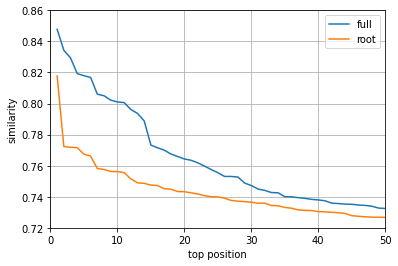

In [41]:
df.plot(xlabel='top position', ylabel='similarity', ylim=[0.72,0.86], xlim=[0,50], grid=True)